In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Gutenberg N-Grams

In this notebook, we will quantitatively explore the text of the [Gutenberg E-Books Project](https://www.gutenberg.org/), a free repository of e-books that are in the public domain. All of the English and German books have been downloaded for this tutorial and a small python package has been made available that allows you to easily parse the text and the associated metadata. 

## Preprocessing procedure

1. Generate `(metadata,text)` RDD from raw data and save in HDFS



## Setting up Python and Spark

Setting up the spark environment can be a bit of a trial and error procedure. Often you'll need to configure settings (in particular dealing with memory) to fit your cluster and your particular application. Below, we will specify a few of the most important ones -- but you can see the full list in the [Spark Configuration guide](http://spark.apache.org/docs/latest/configuration.html) and if you are using YARN there are critical options also listed under the [YARN deployment guide](http://spark.apache.org/docs/latest/running-on-yarn.html).

## Python environment setup

First, we need to make sure that the `pyspark` libraries are accessible in this notebook. To do this, we can add them to the library search path: 

In [3]:
import findspark
findspark.init()

## Runtime settings

In [4]:
import pyspark
from pyspark import SparkConf, SparkContext

### Initializing `SparkConf` 
When starting the Spark runtime through the notebook or inside a script (i.e. when not calling one of the spark scripts like `spark_submit`), you can create a `SparkConf` object that allows you to set up the runtime. This is quite convenient and much more clean and readable than specifying the options on the commandline.

In [5]:
# put the number of executors and cores into variables so we can refer to it later
num_execs = 10
exec_cores = 4

In [6]:
# initializing the SparkConf
conf = SparkConf()

### Executor options

The full list of options is very long, but the basic ones you'll *always* want to at least think about are ones pertaining to the basic configuration of the executors: number of executors, memory per executor, and number of cores per executor. 

A few notes about the memory configuration: the `spark.executor.memory` should not be set to the total memory of the node. Some memory is needed for the OS (including HDFS and other services), and still more is required for the Spark overhead. So in our case here, we have 16 Gb of memory per node but can only use around 12 Gb of this for the executors. Since we need to leave room for 10% YARN overhead, we specify 9 Gb here to be safe. If your executors start dying off for strange reasons, try reducing the memory here. 

In [7]:
conf.set('spark.executor.memory', '9g')
conf.set('spark.executor.instances', str(num_execs))
conf.set('spark.executor.cores', str(exec_cores))

### Memory configuration

Two other key memory options exist, specifying the amount of executor memory reserved for *cached* data and for *shuffle* data. Depending on what your application is doing, you may need more of one or the other. For example, if you are running a lot of iterative operations on a large dataset, you probably want a good amount of memory for RDD caching. On the other hand, if you are doing lots of expensive shuffles that occur when sorting of grouping by key, you may want more shuffle memory. Note that if either one starts to run low, your application won't crash it will simply spill to disk. This usually isn't as bad as it sounds especially if the OS file cache kicks in. 

You can check on the cache memory and shuffle memory in two ways while your application is running. In the Spark UI, you can see the cached RDDs under the `Storage` tab - if they start spilling to disk, this is where you will see it. Similarly, if you are running a large shuffle job, you can click on the stage details in the Spark UI and see the shuffle memory and disk statistics. We will check on both of these later on in this application. 

Here we will set these two options explicitly for completeness, but actually keep the values at their defaults (60%  of the heap for caching, 20% for shuffles). 

In [8]:
conf.set('spark.storage.memoryFraction', 0.6)
conf.set('spark.shuffle.memoryFraction', 0.2)

### Driver memory

The amount of memory allocated to the driver program could be crucial if the driver has to deal with a lot of late-stage aggegation products or if you want to collect a significant chunk of data out of the RDD. You can see how much memory has been allocated to the driver either in the Spark Web UI or in the messages printed to the console at initialization. 

In [9]:
conf.set('spark.yarn.am.memory', '8g')
conf.set('spark.yarn.am.cores', 4)

### `PATH` and `PYTHONPATH`

In some cases we need to tell the executors explicitly where the non-standard python libraries are located (this includes the spark libraries and seems to be new in Spark 1.4.0 -- a bug?). For this, we set the environment variable `PYTHONPATH`. Any other environment variable can be specified in this way, should it be needed.

In [10]:
conf.set('spark.executorEnv.PYTHONPATH', 
         '{home}/spark_workshop/notebooks/gutenberg'.format(home=os.environ['HOME']))

Since we are using a custom python (miniconda), we also set the `PATH` explicitly: 

In [11]:
conf.set('spark.executorEnv.PATH', os.environ['PATH'])

### Starting the `SparkContext`
This is our entry point to the Spark runtime - it is used to push data into spark or load RDDs from disk etc. 

In [12]:
sc = SparkContext(master = 'yarn-client', conf = conf)

If this works successfully, you can check the [YARN application scheduler](http://a3000.hpc-net.ethz.ch:8088/cluster) and you should see your app listed there. Clicking on the "Application Master" link will bring up the familiar Spark Web UI. 

## Make a key-value RDD of book metadata and text

Getting data into spark from a collection of local files is a very common task. A useful pattern to keep in mind is the following: 

1. make a list of filenames and distribute it among the workers
3. "map" each filename to the data you want to get out
4. now you are left with the RDD of raw data distributed among the workers!

In our case of the Gutenberg Project e-book data, we have a directory of `html` files which hold the actual book text, and another directory of associated metadata files (the RDF files). To make your life easier for the purpose of this tutorial, we have made a small python module called `gutenberg_cleanup` that has some handy functions for pulling out the relevant text and metadata out of the raw dataset. 

The [`gutenberg_cleanup`](gutenberg_cleanup.py) module contains three functions that can help with this: `get_gid`, `get_metadata` and `get_text`.

They pretty much do the obvious: 

`get_gid` takes an html path and pulls out the book ID (`gid`)

`get_metadata` takes a `gid` and returns a metadata object with various useful fields that will be used to create a unique key for each book

`get_text` takes a path to an html file and returns the raw text extracted from HTML, cleaned of tags and punctuation and converted to lower case. 

### Initializing the raw dataset using `sc.parallelize`

In [13]:
import glob

# get a list of all html files in the data directory
flist = glob.glob('/cluster/work/sdid/roskarr/gutenberg/html/*html')
print('number of books: ', len(flist))

number of books:  15081


When you use `sc.parallelize` to distribute a dataset across the cluster, you can choose the number of partitions across which to distribute the dataset. The higher the number of partitions, the higher the "parallelism". When Spark subsequently executes maps and reduces on this dataset, it does so by dispatching tasks to different executors, which then request the cores under their control to do the actual work. By increasing the number of partitions, you increase the number of tasks - more tasks gives the Spark scheduler more flexibility in distributing the work across the cluster and therefore maximally leveraging the compute resources at its disposal. In some cases, where a single partition might require a lot of memory it can cause `Out of memory` errors - in such cases, simply reducing the amount of data per task by increasing the parallelism can help. 

Note that as long as the tasks take a few hundred milliseconds the scheduler should have no trouble dispatching them. On the other hand, there is a bit of overhead associated with partitioning the data so you don't want an unreasonably high number of partitions. You can see the [Spark guide](http://spark.apache.org/docs/latest/tuning.html#level-of-parallelism) for a bit more detail. 

Below, we will choose to use 5 times as many partitions as we have cores in the job. 

In [14]:
files_rdd = sc.parallelize(flist, num_execs*exec_cores*5)

In [15]:
files_rdd.take(5)

['/cluster/work/sdid/roskarr/gutenberg/html/1000.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10000.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10001.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10002.html',
 '/cluster/work/sdid/roskarr/gutenberg/html/10003.html']

### Transforming the list of filenames into a `key,value` pair RDD of metadata and text

The raw Gutenberg Project dataset consists of HTML files and files that hold metadata in JSON format. For example: 

In [16]:
!head /cluster/work/sdid/roskarr/gutenberg/html/10000.html

In [17]:
!head /cluster/work/sdid/roskarr/gutenberg/rdf-files/10000/pg10000.rdf

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF xml:base="http://www.gutenberg.org/"
  xmlns:cc="http://web.resource.org/cc/"
  xmlns:dcterms="http://purl.org/dc/terms/"
  xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
  xmlns:pgterms="http://www.gutenberg.org/2009/pgterms/"
  xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
  xmlns:dcam="http://purl.org/dc/dcam/"
>
  <pgterms:ebook rdf:about="ebooks/10000">


#### Data Ingestion procedure

Our first task is to ingest this dataset by doing the following: 

1. convert the html into raw text
2. deal with special characters, HTML tags, etc.
3. match each metadata entry with its corresponding raw text and compose tuples of the type (metadata, text)


These three steps are often the first step of any analysis, and can be quite time consuming to get right. For the purposes of this exercise, we have already built the functions needed to perform these operations. They are found in [`gutenberg_cleanup.py`](gutenberg_cleanup.py) if you want to have a look. 

The important functions are:

* `get_gid` -- returns the Gutenberg ID given an html file
* `get_text` -- get cleaned, raw text out of an html file
* `get_metadata` -- return the metadata given an ID 

These will be used to construct a `key,value` pair RDD. The `key` will be the dictionary returned by `get_metadata`, while the `value` we will use the raw text returned by `get_text`. 

In [18]:
import gutenberg_cleanup
from gutenberg_cleanup import get_metadata, get_text, get_gid

Use the `map` method of `files_rdd` to map the filenames to `(metadata, text)` tuples using `get_gid` and `get_text` functions:

In [19]:
# TODO
id_text_rdd = files_rdd.map(lambda filename: (get_gid(filename), get_text(filename)))

Now we have (ID, text), and we need to make another `map` to get (`metadata, text`) tuples:

In [20]:
# TODO
text_rdd = (id_text_rdd.map(lambda (ID, text): (get_metadata(ID), text)))

So that we don't have to constantly re-load the data off disk, lets cache this RDD: 

In [21]:
%%time
text_rdd.cache()
text_rdd.count()

CPU times: user 41 ms, sys: 6 ms, total: 47 ms
Wall time: 2min 4s


Since we called `count()`, it means that the entire RDD was generated/calculated. This combination of `cache` and `count` is a common way to check how much memory your dataset needs - once `count` completes you can check the memory taken up by the RDD by going to the "Storage" tag of the Spark UI. 

Because the data is cached, next time you try to use `text_rdd` it will be much much quicker. For example, 

In [22]:
%%time
text_rdd.count()

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 2.54 s


15081

As an aside, we could call the native python `map` in exactly the same way (and run it on the local machine only), though this would take much longer to complete, i.e. 

    text = map(lambda f: (get_metadata(get_gid(f)), get_text(f)), flist)

## Save the raw dataset to HDFS (or local storage)

As a final bit of preparation before continuing with analysis, we save the raw data in a way that makes it faster to access later. We don't want to have to read the data off local disk every time we need to repeat some part of the analysis. Instead, it's much more advantageous to use the Hadoop Distributed File System (HDFS) to store the data once we've read it in and put it in a `key,value` format. 

By storing the data in HDFS, we make sure that the system can take advantage of data-locality at a later stage in our analysis. 

In [23]:
# TODO
text_rdd.saveAsPickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

Now, whenever we need it, we can read the data off the HDFS instead: 

In [24]:
# TODO
text_rdd = sc.pickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

In [25]:
%time text_rdd.cache().count()

CPU times: user 27 ms, sys: 4 ms, total: 31 ms
Wall time: 6.6 s


15081

Compare this read time to nearly two minutes it took to read it off the local filesystem initially. If you look at the details for this stage in the Spark UI you can understand why this is: in the column named "locality level", you see that for many tasks it says `NODE LOCAL` while for others it might say `RACK LOCAL`. These mean that either the data chunk was physically present on the disk of the node that was reading it in (`NODE LOCAL`) or it was on one of the nodes on the same switch (`RACK LOCAL`). Of course the additional advantage is not having to deal with the filesystem overhead of 10k+ small files.  

## A first look at the data

Lets have a look at what this RDD looks like -- this is often most easily done using the `first` method of the RDD: 

In [26]:
# TODO
text_rdd.first()

({'birth_year': None,
  'death_year': None,
  'downloads': u'243',
  'first_name': None,
  'gid': 1000,
  'lang': u'en',
  'last_name': None,
  'title': '- No Title -'},
 'pageno position absolute right font medium sansserif textindent pagenoafter color gray content attrtitle lineno position absolute left font medium sansserif textindent linenoafter color gray content attrtitle tocpageref float right pre fontfamily monospace fontsize em whitespace prewrap in italian with no accentsbit text please see my notes about various versions beneath this header copyright laws are changing all over the world be sure to check the copyright laws for your country before posting these files please take a look at the important information in this header we encourage you to keep this file on your own disk keeping an electronic path open for the next readers do not remove this information on contacting project gutenberg to get etexts and further information is included below we need your donations this 

Note that the `key` is now a dictionary, and the `value` is the text, as expected. 

#### First bit of analysis -- how long are the documents? 

Lets have a quick look at the number of words in these books. We'll do this by taking the values of the `text_rdd` (i.e. the text), use the `split` method of the text string to break it up into a list of words, and then use the built-in `len` method to get the length of this sequence. Finally, we will use the `collect` method to extract the numbers to the driver. 

In [27]:
# TODO
text_lengths = (text_rdd.values()
                        .map(lambda text: len(text.split()))).collect()

In [31]:
assert(text_lengths[:10] == [66976, 17180, 8455, 53505, 65001, 50678, 72798, 16377, 30705, 68609])

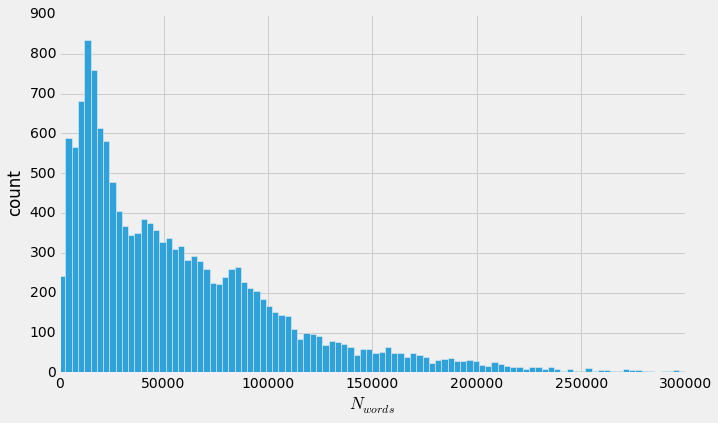

In [37]:
plt.hist(text_lengths, bins = 100, range=[0,3e5]);
plt.xlabel('$N_{words}$'); plt.ylabel('count');

## Broadcast variables: a good way to distribute metadata

As we manipulate the dataset, we will want ready access to the metadata, but at the moment we have no efficient way of working with it. This is because it is either

a) on disk in many thousands of small files (killing the filesystem and making HPC admins furious)

*or*

b) a part of the RDD itself 

So if we want to look at just the metadata, we need to either read it off the disk (bad) or extract it from the RDD every time (expensive). 

For these kinds of situations when passing around some data to all the workers is required, you should use Spark's [broadcast variable](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables) mechanism. By placing data inside a broadcast variable, you make it available to all the workers and it only needs to be sent across the network once. The next time a value from the broadcast variable is needed, it's simply taken from the local executor's memory, incurring no extra network cost. 

In [38]:
# set up the list of fields
metadata_fields = text_rdd.first()[0].keys() # this takes the metadata of the first element and extracts the keys
meta_dict = dict()

for meta in text_rdd.keys().collect() :
    meta_dict[meta['gid']] = {key: meta[key] for key in metadata_fields}

This is now a look-up table that allows us to quickly access all the metadata indexed by `gid`. For example:

In [39]:
meta_dict[101]

{'birth_year': u'1954',
 'death_year': None,
 'downloads': u'352',
 'first_name': u'Bruce',
 'gid': 101,
 'lang': u'en',
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

To get, for example, the author birth year for book with `gid = 101`:

In [40]:
meta_dict[101]['birth_year']

u'1954'

Now we need to create the broadcast variable: 

In [41]:
# call it meta_b for 'broadcast'
meta_b = sc.broadcast(meta_dict)

The underlying data object stored in `meta_b` can be accessed simply by

    > meta_b.value
    
We'll make use of this soon. If you check the console output, you will see an INFO message that the broadcast has been created, i.e. 

```
15/06/24 17:18:44 INFO storage.MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 910.7 KB, free 4.1 GB)
15/06/24 17:18:44 INFO storage.BlockManagerInfo: Added broadcast_6_piece0 in memory on 10.201.20.22:47821 (size: 910.7 KB, free: 4.1 GB)
15/06/24 17:18:44 INFO spark.SparkContext: Created broadcast 6 from broadcast at PythonRDD.scala:403
```

### Save the metadata dictionary for later use
We will need the metadata dictionary at a later point, so we save it to disk now to avoid having to regenerate it later. 

In [42]:
from cPickle import dump

In [43]:
dump(meta_dict, open('{home}/gutenberg_metadata.dump'.format(home=os.environ['HOME']), 'w'))

## Cleaning the data with filtering

Now we're ready to do some quality checks on the data. Let's check out the first couple of metadata entries: 

In [44]:
text_rdd.keys().take(5)

[{'birth_year': None,
  'death_year': None,
  'downloads': u'243',
  'first_name': None,
  'gid': 1000,
  'lang': u'en',
  'last_name': None,
  'title': '- No Title -'},
 {'birth_year': None,
  'death_year': None,
  'downloads': u'269',
  'first_name': None,
  'gid': 10000,
  'lang': u'en',
  'last_name': u'Anonymous',
  'title': u'The Magna Carta'},
 {'birth_year': u'1863',
  'death_year': u'1950',
  'downloads': u'274',
  'first_name': u'Lucius Annaeus',
  'gid': 10001,
  'lang': u'en',
  'last_name': u'Seneca',
  'title': u'Apocolocyntosis'},
 {'birth_year': u'1877',
  'death_year': u'1918',
  'downloads': u'865',
  'first_name': u'William Hope',
  'gid': 10002,
  'lang': u'en',
  'last_name': u'Hodgson',
  'title': u'The House on the Borderland'},
 {'birth_year': u'1833',
  'death_year': u'1923',
  'downloads': u'15',
  'first_name': u'Mary King',
  'gid': 10003,
  'lang': u'en',
  'last_name': u'Waddington',
  'title': u'My First Years as a Frenchwoman, 1876-1879'}]

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all the elements that have `None` for `title`, `first_name`, `last_name`, or `birth_year`. In addition, filter out the data with "BC" in either birth or death year. 

The `filter_func` has already been defined for you, but you need to apply it to `text_rdd`

In [45]:
def filter_func(meta) : 
    no_none = all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])
    if not no_none : 
        return False
    else : 
        no_birth_bc = 'BC' not in meta['birth_year']
        no_death_bc = True if meta['death_year'] is None else 'BC' not in meta['death_year']
        return no_birth_bc + no_death_bc

In [46]:
# TODO
filtered_rdd = text_rdd.filter(lambda (meta, text): filter_func(meta))

In [47]:
filtered_rdd.keys().take(5)

[{'birth_year': u'1863',
  'death_year': u'1950',
  'downloads': u'274',
  'first_name': u'Lucius Annaeus',
  'gid': 10001,
  'lang': u'en',
  'last_name': u'Seneca',
  'title': u'Apocolocyntosis'},
 {'birth_year': u'1877',
  'death_year': u'1918',
  'downloads': u'865',
  'first_name': u'William Hope',
  'gid': 10002,
  'lang': u'en',
  'last_name': u'Hodgson',
  'title': u'The House on the Borderland'},
 {'birth_year': u'1833',
  'death_year': u'1923',
  'downloads': u'15',
  'first_name': u'Mary King',
  'gid': 10003,
  'lang': u'en',
  'last_name': u'Waddington',
  'title': u'My First Years as a Frenchwoman, 1876-1879'},
 {'birth_year': u'1864',
  'death_year': u'1948',
  'downloads': u'9',
  'first_name': u'Anna Robertson Brown',
  'gid': 10004,
  'lang': u'en',
  'last_name': u'Lindsay',
  'title': u'The Warriors'},
 {'birth_year': u'1775',
  'death_year': u'1861',
  'downloads': u'17',
  'first_name': u'George',
  'gid': 10005,
  'lang': u'en',
  'last_name': u'Tucker',
  'title

How many do we have left? 

In [50]:
nfiltered = filtered_rdd.count()
print('number of books after filtering: ', nfiltered)
assert(nfiltered == 11872)

number of books after filtering:  11872


A final bit of cleanup: 

some of the books end up split across multiple entries. Since it's the same book, each of the entries should have the same `gid`. 

To check for this we will use one of the most basic and common MapReduce patterns -- the key count: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. In this case, the `key` will be `gid`
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result in descending order and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

So, the procedure should be : 

1. `map` the `filtered_rdd` using a lambda function to contain (`gid`, 1) tuples
2. `reduceByKey`
3. `sortBy` (specify decreasing order, see the API) 

In [51]:
from operator import add

In [54]:
# FILL IN: map the filtered_rdd to contain just the tuple (gid, 1)
map_filtered = filtered_rdd.map(lambda (meta, text): (meta['gid'],1))

# reduce the map_filtered rdd by key to get the total counts per gid
reduced_gid_rdd = map_filtered.reduceByKey(add)

# sort by count and print out the top 10
reduced_gid_rdd.sortBy(lambda (key, count): count, False).take(10)

[(6478, 43),
 (3772, 40),
 (8700, 35),
 (3332, 33),
 (12233, 29),
 (3425, 23),
 (2440, 16),
 (6475, 15),
 (12145, 9),
 (12383, 7)]

In [57]:
assert(_ == [(6478, 43), (3772, 40), (8700, 35), (3332, 33), (12233, 29), (3425, 23), (2440, 16), (6475, 15), (12145, 9), (12383, 7)])

Note that there are several transformations here that lead to the final result, `sorted_reduced`. A common syntax is to group them all together, by enclosing them in `( )` and chaining them: 

In [58]:
# TODO
(filtered_rdd.map(lambda (meta, text): (meta['gid'], 1))
             .reduceByKey(add)
             .sortBy(lambda (key,count): count, False)
             .take(10))

[(6478, 43),
 (3772, 40),
 (8700, 35),
 (3332, 33),
 (12233, 29),
 (3425, 23),
 (2440, 16),
 (6475, 15),
 (12145, 9),
 (12383, 7)]

Looks like we have a few that are made up of multiple sections. To combine them, we will use `reduceByKey` which will result in having an RDD of `gid`'s as keys and the combined text of each `gid`. The reduction function in `reduceByKey` can be a simple in-line function that just adds two elements together (but can't be the `add` function because that expects the arguments to be numbers). 

In [59]:
cleaned_rdd = (filtered_rdd.map(lambda (meta, text): (meta['gid'], text))
                           .reduceByKey(lambda a,b: a+b))

As a simple sanity check, lets look at `gid`=6478, which according to the cell above has 43 sections in the original dataset: 

In [60]:
len(filtered_rdd.map(lambda (meta, text): (meta['gid'],1))
                .lookup(6478))

43

In [61]:
len(cleaned_rdd.lookup(6478))

1

To avoid having to do all these pre-processing steps again at a later point, lets also save the `cleaned_rdd`:

In [62]:
cleaned_rdd.saveAsPickleFile('/user/roskarr/gutenberg/cleaned_rdd')

This is now saved in the directory we specified, one file per partition:

In [63]:
!hadoop fs -ls /user/roskarr/gutenberg/cleaned_rdd | head

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/08/31 17:24:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 201 items
-rw-r--r--   3 roskarr supergroup          0 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/_SUCCESS
-rw-r--r--   3 roskarr supergroup   91335240 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00000
-rw-r--r--   3 roskarr supergroup   27271247 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00001
-rw-r--r--   3 roskarr supergroup   19972960 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00002
-rw-r--r--   3 roskarr supergroup   24205835 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00003
-rw-r--r--   3 roskarr supergroup   20983140 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00004
-rw-r--r--   3 roskarr supergroup   24063989 2015-08-31 17:24 /user/roskarr/gutenberg/cleaned_rdd/part-00005
-rw-r--r--   3 roskarr sup

### Recap of steps up until this point

We've done quite a lot already with our dataset in Spark, although it's only the beginning!

1. created an RDD of filenames (`filename_rdd`)
2. transformed the `filename_rdd` into an RDD of `(metadata, text)` (`text_rdd`); we also saved this to HDFS
3. filtered out data with bad metadata, e.g. missing author names etc.
3. cleaned up the entries a bit more by merging ones with identical IDs; we called this `cleaned_rdd`

## Shutting down the `SparkContext`

Now that the pre-processing is done, we will shut down the `SparkContext` before continuing to the data analysis notebook. We have all of our results saved in HDFS, so to continue from where we left off will just require loading data from there. 

In [64]:
sc.stop()